# Figure 3: Mapping flower colors

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box, Polygon
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer
import cv2

In [2]:
color_df = pd.read_csv('../datasets/1-clusters/cluster1.csv')
color_df

,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035
...,...,...,...,...,...,...,...,...,...
20623,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552
20624,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277
20625,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752
20626,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498


### If multiple rows with the same gbifID (because of multiple pictures for one observation), choose a random one

In [3]:
color_df_reduced = (
    color_df.groupby("gbifID", sort=False, group_keys=False)
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)
color_df_reduced

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_85686/411184798.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035
...,...,...,...,...,...,...,...,...,...
16582,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552
16583,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277
16584,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752
16585,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498


### Plot the raw data:

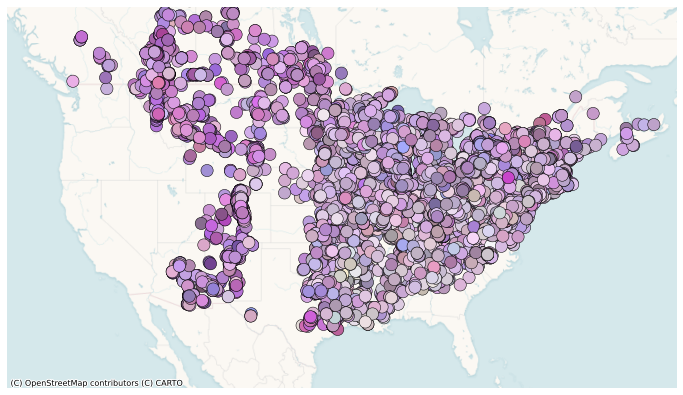

In [4]:
# bounds in lat/lon EPSG:4326
# start here bc uses wgs84 and good for real world data
min_lon, min_lat, max_lon, max_lat = -130, 24, -59, 54  # adjust as needed

# make the bounding box geo
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs="EPSG:4326")

# convert to web mercator EPSG:3857 bc better for mapping
bbox_gdf = bbox_gdf.to_crs(epsg=3857)
xmin, ymin, xmax, ymax = bbox_gdf.total_bounds

# get geodataframe of points, again starting w 4326 and converting
gdf = gpd.GeoDataFrame(color_df_reduced, geometry=[Point(xy) for xy in zip(color_df_reduced.longitude, color_df_reduced.latitude)], crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

#######
# plotting it up!
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf.hex, s=150, alpha=1,edgecolors='k', linewidths=0.5)

# Set the axis limits using the bounding box coordinates in EPSG:3857
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)

ax.set_axis_off()

plt.savefig("../figures/figure_puzzling/indiv_color_map.pdf")
plt.show()

# Now plot the averaged grid cells

#### a bunch of helper functions that we will string together

In [5]:
##########
# recycling color conversion functions from notebook 5
def lab_to_rgb(lab):
    """convert (L,a,b) in OpenCV's Lab to (r,g,b) in [0,255]"""
    arr = np.array([[lab]], dtype=np.uint8) # basically makes a single-pixel image
    rgb = cv2.cvtColor(arr, cv2.COLOR_LAB2RGB)[0][0]
    return tuple(int(x) for x in rgb)

def rgb_to_hex(rgb):
    # rgb should be a tuple like (R, G, B)
    return '#{:02x}{:02x}{:02x}'.format(*rgb)
##########

# start by making a geodataframe from our df
def create_gdf(df):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)
    return gdf

# define a grid with cell size in m, we want EPSG:3857
def create_square_grid(min_lon, min_lat, max_lon, max_lat, cell_size=200000): # 200km
    bbox = box(min_lon, min_lat, max_lon, max_lat)
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs="EPSG:4326").to_crs(epsg=3857)
    xmin, ymin, xmax, ymax = bbox_gdf.total_bounds
    polygons = []
    for x in np.arange(xmin, xmax, cell_size):
        for y in np.arange(ymin, ymax, cell_size):
            polygons.append(Polygon([(x, y), (x+cell_size, y), (x+cell_size, y+cell_size), (x, y+cell_size)]))
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs="EPSG:3857")
    return grid_gdf

# the lab codes in the df are in strings.... let's convert 
# them to np arrays of integers
def parse_lab(lab):
    if isinstance(lab, str):
        lab = lab.strip('()').split(',')
        return np.array([int(x) for x in lab])
    elif isinstance(lab, tuple):
        return np.array(lab)
    else:
        return np.array([np.nan, np.nan, np.nan])

def average_colors_in_grid(gdf_points, grid_gdf):
    joined = gpd.sjoin(gdf_points, grid_gdf, how='left', predicate='within')

    # the csv reads the lab vals in as strings.... so this helps parse
    joined['lab_numeric'] = joined['lab'].apply(parse_lab) 

    # now average 
    grouped = joined.groupby('index_right')['lab_numeric'].apply(
        lambda labs: np.nanmean(np.stack(labs), axis=0)
    ).reset_index()

    grouped['avg_hex'] = grouped['lab_numeric'].apply(
        lambda lab: rgb_to_hex(lab_to_rgb(np.round(lab).astype(np.uint8)))
    )

    grid_gdf['avg_hex'] = grouped.set_index('index_right')['avg_hex']
    return grid_gdf

#### finally, make the map

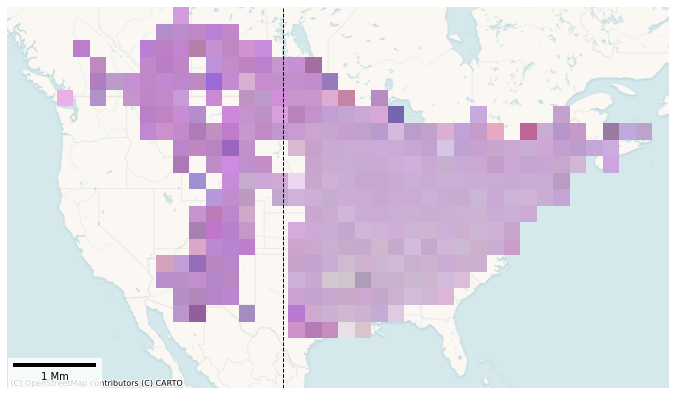

In [6]:
gdf = create_gdf(color_df_reduced)

min_lon, min_lat, max_lon, max_lat = -130, 24, -59, 54
grid = create_square_grid(min_lon, min_lat, max_lon, max_lat)
grid_with_color = average_colors_in_grid(gdf, grid)

grid_with_data = grid_with_color.dropna(subset=['avg_hex'])

fig, ax = plt.subplots(figsize=(12, 7))

if not grid_with_data.empty:
    grid_with_data.plot(ax=ax, color=grid_with_data['avg_hex'], edgecolor='none', alpha=1.0)

xmin, ymin, xmax, ymax = grid.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# add the vertical line - this transformer package is cool.
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x_line, _ = transformer.transform(-100, 0)
ax.axvline(x=x_line, color='black', linestyle='--', linewidth=1)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off()

scalebar = ScaleBar(dx=1, units="m", location='lower left', pad=0.5, color='black', box_color='white', box_alpha=0.8, length_fraction=0.2)
ax.add_artist(scalebar)

plt.savefig("../figures/figure_puzzling/avg_color_map.pdf")
plt.show()